In [1]:
%load_ext autoreload
%autoreload 2

from datasets import DataCifar10
from models import MultiLayerConvNet
from optimers import OptimerSGD, OptimerAdam
from utils import check_accuracy, check_gradient
from utils import show_training_infos, show_training_info

In [2]:
# load data
dataloader = DataCifar10('./datasets/cifar-10-batches-py', norm_dis_mean=True, norm_div_std=False,
                         num_val=1000, num_train=49000, num_test=1000)
    
print('Training data shape: ', dataloader.x_train.shape)
print('Training labels shape: ', dataloader.y_train.shape)
print('Validating data shape: ', dataloader.x_val.shape)
print('Validating labels shape: ', dataloader.y_val.shape)
print('Testing data shape: ', dataloader.x_test.shape)
print('Testing labels shape: ', dataloader.y_test.shape)

Training data shape:  (49000, 3, 32, 32)
Training labels shape:  (49000,)
Validating data shape:  (1000, 3, 32, 32)
Validating labels shape:  (1000,)
Testing data shape:  (1000, 3, 32, 32)
Testing labels shape:  (1000,)


In [3]:
def get_init_model(hyperparams, device='cpu'):
    return MultiLayerConvNet([3, 32, 32], 10, hyperparams=hyperparams, seed=99, device=device)

# Sanity check

### Gradient check

In [4]:
# init model
model = get_init_model({'reg': 0.6, 'init_scale': None, 'nums_conv': [32], 'nums_hidden': [32]}, device='gpu')

# sanity check
loss = model.backward(dataloader.x_train[0: 100, :], dataloader.y_train[0: 100])
print('Sanity check result:')
print('Init loss is', loss)

# gradient check
for i in range(1):
    print('\nGradient check result - ', i + 1, ':')
    check_gradient(model, dataloader.x_train[0: 100, :], dataloader.y_train[0: 100], h=0.001)

Sanity check result:
Init loss is 3.124665

Gradient check result -  1 :
Layer | Key | Numerical gradient | Calculated gradient | Relative error
Spatial_BatchNorm gamma 0.8106231689453125 0.81181943 0.0014746471996581933
Spatial_BatchNorm beta -0.0635385513305664 -0.06365801 0.0018782765942404165
Conv W -0.028252601623535156 -0.028177842 0.0026496025992194844
Conv b -0.044345855712890625 -0.044749655 0.009064409960799274
Linear W 0.060677528381347656 0.06073459 0.0009399436052246676
Linear b 0.04112720489501953 0.041196268 0.0016778484767703422
Linear W -0.07128715515136719 -0.07125881 0.0003976542995900732
Linear b -0.013947486877441406 -0.014055339 0.007702923442532636


### Overfit small dataset

In [9]:
# load small dataset
smallloader = DataCifar10('./datasets/cifar-10-batches-py', 
                          num_train=100, num_test=100, num_val=100)

# init model
model = get_init_model({'reg': 0.}, device='gpu')

optimer = OptimerAdam({'learn_rate': 1e-3, 
                       'num_iters': 200, 
                       'batch_size': 50}, print_every=20)

# train model
optimer.train(model, smallloader)

# save model
model.save('./saves/MultiLayerConvNet/model_small.pkl')

0 / 200 loss is 2.3025851
20 / 200 loss is 2.0407667
40 / 200 loss is 1.4524845
60 / 200 loss is 0.82858336
80 / 200 loss is 0.5546423
100 / 200 loss is 0.26341158
120 / 200 loss is 0.19558778
140 / 200 loss is 0.19880354
160 / 200 loss is 0.13557081
180 / 200 loss is 0.15549242


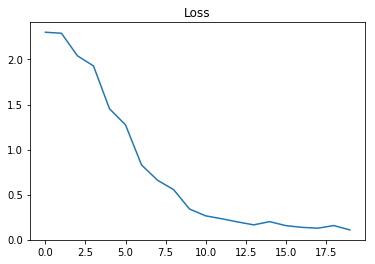

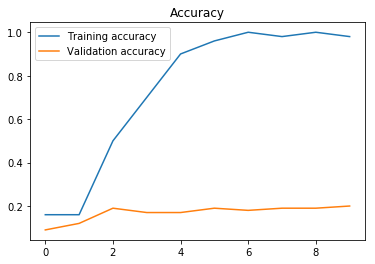

In [10]:
# plot loss curve
show_training_info(optimer)

In [11]:
# load model
model = MultiLayerConvNet.load('./saves/MultiLayerConvNet/model_small.pkl')

# check accuracy
scores = model.predict(smallloader.x_test)
accuracy = check_accuracy(scores, smallloader.y_test)
    
print('The accuracy on testing dataset is ', accuracy)

The accuracy on testing dataset is  0.15


# Run time test

### Backpropagation

In [5]:
# init model
hyperparam = {'reg': 0.01, 'init_scale': None, 'nums_conv': [16], 'nums_hidden': [16]}

# init model
model1 = get_init_model(hyperparam, device='cpu')
model2 = get_init_model(hyperparam, device='gpu')

# the backpropagation
print('\nRun time for CPU model:')
loss1 = model1.backward(dataloader.x_train[0: 256, :], dataloader.y_train[0: 256], print_time=True)

print('\nRun time for GPU model:')
loss2 = model2.backward(dataloader.x_train[0: 256, :], dataloader.y_train[0: 256], print_time=True)


Run time for CPU model:

Forward time: 0.6053717136383057
     Spatial_BatchNorm : 0.051779747009277344
     Conv : 0.3186936378479004
     ReLU : 0.043019771575927734
     MaxPool : 0.18734979629516602
     Linear : 0.0038068294525146484
     ReLU : 8.511543273925781e-05
     Linear : 0.0006368160247802734

Backward time: 0.38763427734375
     Linear : 0.14172911643981934
     ReLU : 0.0327301025390625
     Linear : 0.16017603874206543
     MaxPool : 0.0038542747497558594
     ReLU : 6.079673767089844e-05
     Conv : 6.508827209472656e-05
     Spatial_BatchNorm : 0.010250329971313477

Reg time: 0.0003199577331542969

Run time for GPU model:

Forward time: 0.023232221603393555
     Spatial_BatchNorm : 0.005196332931518555
     Conv : 0.00974893569946289
     ReLU : 0.0010993480682373047
     MaxPool : 0.0062067508697509766
     Linear : 0.0004265308380126953
     ReLU : 0.00022721290588378906
     Linear : 0.00032711029052734375

Backward time: 0.024204730987548828
     Linear : 0.009

### Parameters modification

In [6]:
# init optimer
optimer = OptimerAdam({'learn_rate': 1e-3, 'learn_rate_decay':0.95, 'num_iters': 1, 'batch_size': 256}, 
                      print_every=None)

# parameter modify
print('\nRun time for CPU model:')
optimer.train(model1, dataloader, print_time=True)

print('\nRun time for GPU model:')
optimer.train(model2, dataloader, print_time=True)


Run time for CPU model:
Time: 0.7279298305511475
    Load data: 0.0029096603393554688
    Backpropagate: 0.7239573001861572
    Modify parameters: 0.0010569095611572266
    Others: 5.9604644775390625e-06

Run time for GPU model:
Time: 0.0471186637878418
    Load data: 0.0021276473999023438
    Backpropagate: 0.03924202919006348
    Modify parameters: 0.00574493408203125
    Others: 4.0531158447265625e-06


# Train multi-layer convnet

In [20]:
# init model
if True:
    model = get_init_model({'reg': 0.01, 'init_scale': None, 
                            'nums_conv': [32, 64, 128], 'nums_hidden': [256]}, device='gpu')
else:
    model = MultiLayerConvNet.load('./saves/MultiLayerConvNet/model.pkl')

optimer = OptimerAdam({'learn_rate': 1e-3, 
                       'learn_rate_decay':0.95,
                       'num_iters': 6000, 
                       'batch_size': 128}, print_every=200, record_every=100)

# train model
optimer.train(model, dataloader)

# save model
model.save('./saves/MultiLayerConvNet/model.pkl')

0 / 6000 loss is 3.6013892
200 / 6000 loss is 1.2326652
400 / 6000 loss is 0.89248145
600 / 6000 loss is 0.78582066
800 / 6000 loss is 0.6870721
1000 / 6000 loss is 0.5419202
1200 / 6000 loss is 0.6188348
1400 / 6000 loss is 0.49370778
1600 / 6000 loss is 0.5329258
1800 / 6000 loss is 0.44893044
2000 / 6000 loss is 0.35726166
2200 / 6000 loss is 0.47899953
2400 / 6000 loss is 0.3359823
2600 / 6000 loss is 0.21608697
2800 / 6000 loss is 0.33617958
3000 / 6000 loss is 0.12611827
3200 / 6000 loss is 0.17588282
3400 / 6000 loss is 0.253989
3600 / 6000 loss is 0.18388426
3800 / 6000 loss is 0.17481433
4000 / 6000 loss is 0.12966199
4200 / 6000 loss is 0.18280783
4400 / 6000 loss is 0.15726224
4600 / 6000 loss is 0.099039145
4800 / 6000 loss is 0.11993253
5000 / 6000 loss is 0.050211187
5200 / 6000 loss is 0.053248618
5400 / 6000 loss is 0.040186036
5600 / 6000 loss is 0.11469938
5800 / 6000 loss is 0.06292169


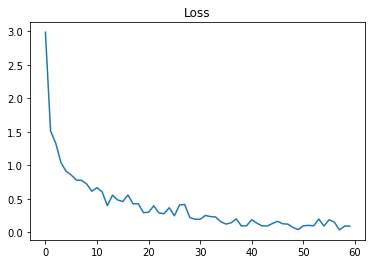

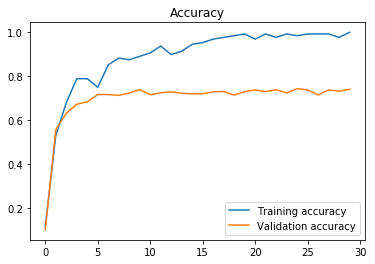

In [18]:
# plot loss curve
show_training_info(optimer)

In [21]:
# load model
model = MultiLayerConvNet.load('./saves/MultiLayerConvNet/model.pkl')

# check accuracy
scores = model.predict(dataloader.x_test)
accuracy = check_accuracy(scores, dataloader.y_test)
    
print('The accuracy on testing dataset is', accuracy)

The accuracy on testing dataset is 0.743


# Check all the trained models

In [34]:
def check_model(model_name):
    # load model
    model = MultiLayerConvNet.load('./saves/MultiLayerConvNet/' + model_name)

    # check accuracy
    scores = model.predict(dataloader.x_test)
    accuracy = check_accuracy(scores, dataloader.y_test)

    print('<', model_name, '>', 'Testing accuracy:', accuracy)
    
# check the trained models
check_model('model_conv_16_32_hide_100.pkl')
check_model('model_conv_16_32_64_64_hide_300.pkl')
check_model('model_conv_16_32_64_64_128_hide_512.pkl')

< model_conv_16_32_hide_100.pkl > Testing accuracy: 0.707
< model_conv_16_32_64_64_hide_300.pkl > Testing accuracy: 0.775
< model_conv_16_32_64_64_128_hide_512.pkl > Testing accuracy: 0.752
